# Clasificación de modelo LogRes sobre TwinViews

Esto es una prueba preliminar para la comparación de modelos de ```model_comparison.ipynb```.

### Imports

In [1]:
import json
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google import genai

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    roc_curve,
    auc,
    ConfusionMatrixDisplay
)

import umap
from datasets import load_dataset
from utils.embedding import embed_texts_in_batches

In [2]:
os.environ["GOOGLE_API_KEY"] = ""
client = genai.Client(api_key=os.environ["GOOGLE_API_KEY"])

In [3]:
file_name = '../data/embeddings/tweets-embeddings.parquet'
dataset = pd.read_parquet(file_name)
X = np.vstack(dataset["embedding"])
y = dataset["label"].values

### Procesamiento y clasificación

In [4]:
train, test = train_test_split(dataset, test_size=0.4, random_state=42, stratify=dataset["label"])

X_train = np.vstack(train["embedding"])
y_train = train["label"].values
X_test  = np.vstack(test["embedding"])
y_test  = test["label"].values

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std  = scaler.transform(X_test)

In [5]:
X_train.shape

(5268, 768)

In [6]:
lr = LogisticRegression(max_iter=10000)
lr.fit(X_train_std, y_train)

train_acc = lr.score(X_train_std, y_train)
test_acc  = lr.score(X_test_std, y_test)

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

Train Accuracy: 0.8618
Test Accuracy: 0.7190


### Evaluación de resultados

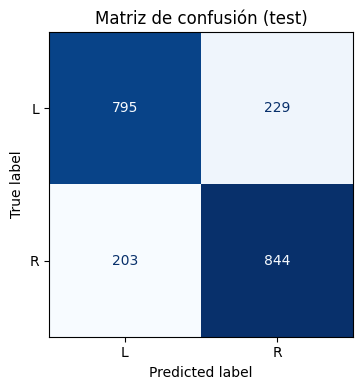

In [7]:
y_pred = lr.predict(X_test_std)

cm = confusion_matrix(y_test, y_pred, labels=["L", "R"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["L", "R"])
fig, ax = plt.subplots(figsize=(4,4))
disp.plot(ax=ax, cmap="Blues", values_format="d", colorbar=False)
ax.set_title("Matriz de confusión (test)")
plt.tight_layout()
plt.show()

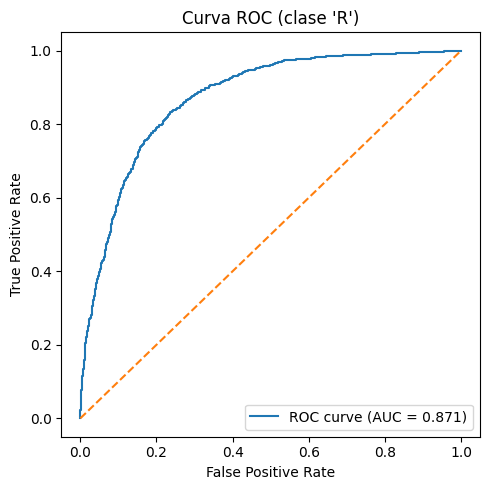

In [8]:
y_proba = lr.predict_proba(X_test_std)[:, lr.classes_.tolist().index("R")]

fpr, tpr, thresholds = roc_curve(y_test, y_proba, pos_label="R")
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC (clase 'R')")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

In [9]:
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, metric="cosine", random_state=42)
X_2d = reducer.fit_transform(X)

/Users/diegolarraguibel/Desktop/Proyectos/inclinacion_politica/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


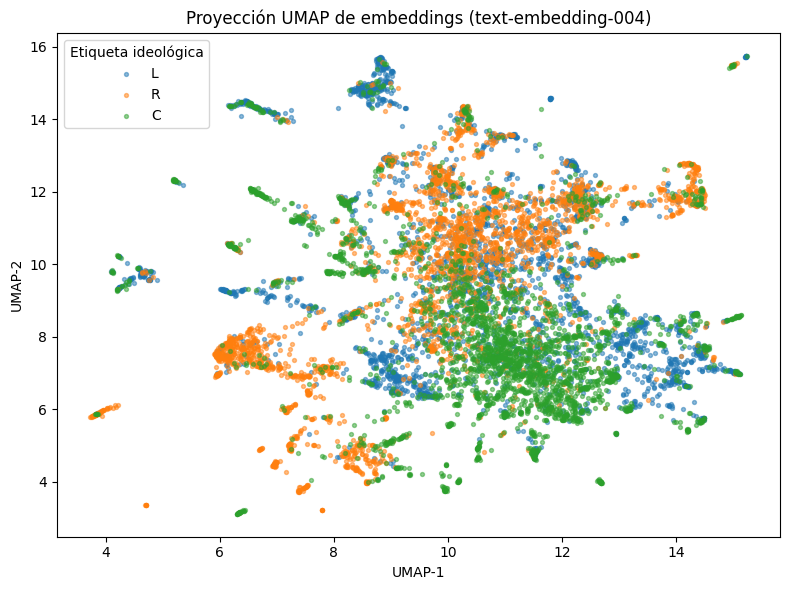

In [10]:
plt.figure(figsize=(8,6))

mask_left = (y == "L")
mask_right = (y == "R")
mask_center = (y == "C")

plt.scatter(X_2d[mask_left, 0], X_2d[mask_left, 1], s=8, alpha=0.5, label="L",)
plt.scatter(X_2d[mask_right, 0], X_2d[mask_right, 1], s=8, alpha=0.5, label="R",)
plt.scatter(X_2d[mask_center, 0], X_2d[mask_center, 1], s=8, alpha=0.5, label="C",)

plt.legend(title="Etiqueta ideológica")
plt.title("Proyección UMAP de embeddings (text-embedding-004)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.tight_layout()
plt.show()